In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [66]:
import pandas as pd       
import os 
import math 
import seaborn as sns
sns.set()
import numpy as np
import random
import matplotlib.pyplot as plt  
import IPython.display as ipd  # To play sound in the notebook
import librosa
import librosa.display
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

# Working path
path = "/content/drive/My Drive/DLAS/data/speech-accent-archive"
os.chdir(path)
print(os.listdir())

# Consistent Seeding
SEED = 11
os.environ['PYTHONHASHSEED']= str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

['recordings', 'reading-passage.txt', 'speakers_all.csv', 'speaker_info_final.csv']


In [0]:
# Constants
TEST_SPLIT = 0.2
TRAIN_VAL_SPLIT = 0.15
OPTIMIZER = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
LOSS = 'binary_crossentropy'
EPOCHS = 50
BATCH_SIZE = 64                   
VERBOSE = 1 # 0 = silent, 1 = progress bar, 2 = one line per epoch
CLASS_WEIGHT = None
CLASSIFICATION_THRESHOLD = 0.5

In [86]:
# Checking if embeddings order is equal to csv info order (to get labels correctly)
speakers_info = pd.read_csv('speaker_info_final.csv')

speakers_info['sex'] = speakers_info['sex'].replace({'famale':'female'})

speakers_info = speakers_info.sort_values('file_name')
speakers_info["filename_wav"] = speakers_info["file_name"].apply(lambda x: x.split(".")[0]+".wav")
wav_files_from_df = speakers_info["filename_wav"].tolist()

wav_files_from_drive = list(sorted(os.listdir("recordings/recordings_wav")))

print("Same order?", wav_files_from_df == wav_files_from_drive)
print(speakers_info.sex.value_counts())
speakers_info.head()

Same order? True
male      1102
female    1036
Name: sex, dtype: int64


,age,age_onset,birthplace,native_language,sex,country,file_name,filename_wav
0,27.0,9.0,"virginia, south africa",afrikaans,female,south africa,afrikaans1.mp3,afrikaans1.wav
1,40.0,5.0,"pretoria, south africa",afrikaans,male,south africa,afrikaans2.mp3,afrikaans2.wav
2,43.0,4.0,"pretoria, transvaal, south africa",afrikaans,male,south africa,afrikaans3.mp3,afrikaans3.wav
3,26.0,8.0,"pretoria, south africa",afrikaans,male,south africa,afrikaans4.mp3,afrikaans4.wav
4,19.0,6.0,"cape town, south africa",afrikaans,male,south africa,afrikaans5.mp3,afrikaans5.wav


In [87]:
# Loading embeddings and getting labels
X = np.load('recordings/audio_embeddings_hop_0.1_dur_5_librosa_fast.npy')
le = LabelEncoder()
y = le.fit_transform(speakers_info.sex.values)

X = np.expand_dims(X, axis=-1)
y = np.expand_dims(y, axis=-1)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("y classes:", le.classes_)

X shape: (2138, 41, 128, 1)
y shape: (2138, 1)
y classes: ['female' 'male']


In [88]:
# Splitting train, val, test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=TEST_SPLIT, stratify=y, random_state=SEED, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=TRAIN_VAL_SPLIT, stratify=y_train_val, random_state=SEED, shuffle=True)

print("train shape:", X_train.shape)
print("val shape:", X_val.shape)
print("test shape:", X_test.shape)

train shape: (1453, 41, 128, 1)
val shape: (257, 41, 128, 1)
test shape: (428, 41, 128, 1)


In [0]:
def CNN_model(input_shape, output_shape):

  model = Sequential()

  model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape)) # (30, 32, 1)))
  model.add(Conv2D(16, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))

  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape)) # (30, 32, 1)))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(output_shape, activation='sigmoid'))

  return model

In [90]:
model = CNN_model(X_train.shape[1:], 1)
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
model.summary()

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 39, 126, 16)       160       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 37, 124, 16)       2320      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 18, 62, 16)        0         
________________________

In [91]:
model_history = model.fit(X_train, y_train, 
                          epochs=EPOCHS, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, 
                          validation_data=(X_val, y_val),
                          verbose=VERBOSE,
                          class_weight=CLASS_WEIGHT
                         ).history

Train on 1453 samples, validate on 257 samples
Epoch 1/50
Executing op __inference_keras_scratch_graph_57615 in device /job:localhost/replica:0/task:0/device:GPU:0
1453/1453 [==============================] - 1s 516us/step - loss: 0.7019 - accuracy: 0.4790 - val_loss: 0.6959 - val_accuracy: 0.5058
Epoch 2/50
1453/1453 [==============================] - 0s 201us/step - loss: 0.6940 - accuracy: 0.5237 - val_loss: 0.6907 - val_accuracy: 0.5253
Epoch 3/50
1453/1453 [==============================] - 0s 197us/step - loss: 0.6900 - accuracy: 0.5423 - val_loss: 0.6858 - val_accuracy: 0.5681
Epoch 4/50
1453/1453 [==============================] - 0s 201us/step - loss: 0.6837 - accuracy: 0.5747 - val_loss: 0.6808 - val_accuracy: 0.6732
Epoch 5/50
1453/1453 [==============================] - 0s 207us/step - loss: 0.6789 - accuracy: 0.6160 - val_loss: 0.6758 - val_accuracy: 0.7821
Epoch 6/50
1453/1453 [==============================] - 0s 201us/step - loss: 0.6732 - accuracy: 0.6352 - val_loss: 0

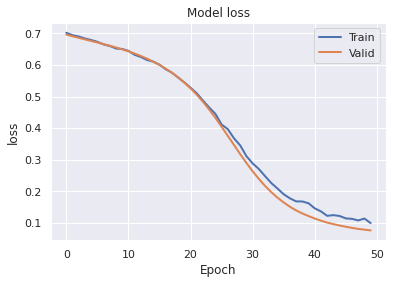

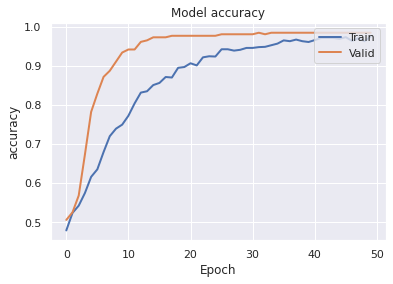

In [92]:
# Ploting loss and acurracy for both train and validation
for graph in ['loss', 'accuracy']:
    plt.plot(model_history[graph], linewidth=2, label='Train')
    plt.plot(model_history['val_'+graph], linewidth=2, label='Valid')
    plt.legend(loc='upper right')
    plt.title('Model '+graph)
    plt.ylabel(graph)
    plt.xlabel('Epoch')
    plt.show()

Executing op __inference_keras_scratch_graph_66406 in device /job:localhost/replica:0/task:0/device:GPU:0


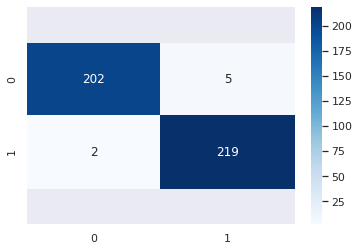

              precision    recall  f1-score   support

       False       0.99      0.98      0.98       207
        True       0.98      0.99      0.98       221

    accuracy                           0.98       428
   macro avg       0.98      0.98      0.98       428
weighted avg       0.98      0.98      0.98       428



In [93]:
# Predicting with the model
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)
y_pred = (y_pred > CLASSIFICATION_THRESHOLD).reshape(-1,1)
y_test = (y_test > CLASSIFICATION_THRESHOLD).reshape(-1,1)

hm = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt='d')# font size
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

print(classification_report(y_test, y_pred))